<a href="https://colab.research.google.com/github/KevinHern/SP1-Educational-Material/blob/main/demos/SP1_06_CNN_and_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0) Preparations

Computer Vision problems require A LOT of processing power. If you use your processor, it will take ages to train.

Change the runtime to GPU and you will have a massive boost in your processing power; training will take less time!

In [1]:
# ----- Libraries ----- #

# This is the main Library that allows us to work with Neural Networks
import tensorflow as tf

# For graph plotting
import matplotlib.pyplot as plt
from tensorflow.math import confusion_matrix
from tensorflow.keras.utils import image_dataset_from_directory

# For dataset manipulation
from keras.preprocessing import image
import numpy as np

# Miscellaneous Libraries
import os, os.path

# For visualizing more complex graphs
import seaborn as sns

# Global constant for training acceleration
AUTOTUNE = tf.data.AUTOTUNE

# 1) Dataset

## Setting up API

To get access to Kaggle Datasets in Google Colab, refer to [this article](https://medium.com/unpackai/how-to-use-kaggle-datasets-in-google-colab-f9b2e4b5767c) about how to setup the API.



In [2]:
# Cell used to link Kaggle API and Google Colab
from google.colab import files
files.upload() #upload kaggle.json

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle (1).json
kaggle.json


## Downloading

In [3]:
# Downloading Dataset as ZIP
# Provide the API command here, don't forget to add the exclamation symbol at the beginning!
# The API command can be obtained in the Kaggle's page → Dataset Page → 3 dots (next to the black download button) → COPY API COMMAND
!kaggle datasets download -d jeffheaton/iris-computer-vision

# Unzipping Dataset
!unzip iris-computer-vision.zip -d data

iris-computer-vision.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  iris-computer-vision.zip
  inflating: data/iris-setosa/iris-01ab65973fd487a6cee4c5af1551c42b264eec5abab46bffd7c307ffef647e11.jpg  
  inflating: data/iris-setosa/iris-0797945218a97d6e5251b4758a2ba1b418cbd52ce4ef46a3239e4b939bd9807b.jpg  
  inflating: data/iris-setosa/iris-0c826b6f4648edf507e0cafdab53712bb6fd1f04dab453cee8db774a728dd640.jpg  
  inflating: data/iris-setosa/iris-0ff5ba898a0ec179a25ca217af45374fdd06d606bb85fc29294291facad1776a.jpg  
  inflating: data/iris-setosa/iris-1289c57b571e8e98e4feb3e18a890130adc145b971b7e208a6ce5bad945b4a5a.jpg  
  inflating: data/iris-setosa/iris-16f7515e1d6aa6d7dd3af4bca38c8065bfab9d426c5fd75b3c4bc51d737fb9d0.jpg  
  inflating: data/iris-setosa/iris-1e80d2d6f3e9cf96c1cb33f3e47f3e5a3f4a6eb26fa3ab479d462e1ac837ba66.jpg  
  inflating: data/iris-setosa/iris-1f941001f508ff1bd492457a90da64e52c461bfd64587a3cf7c6bf1bcb35adab.jpg  
  inflati

## Setting up Directories

In [4]:
# Setting up Macro Variables
test_split = 0.2

# Directories
base_dir = "./data/"
train_dir = base_dir + "train/"
test_dir = base_dir + "test/"
setosa_dir = base_dir + "setosa"
versicolour_dir = base_dir + "versicolour"
virginica_dir = base_dir + "virginica"

In [5]:
# Renaming Directory to something more comfortable
!mv data/iris-setosa data/setosa
!mv data/iris-versicolour data/versicolour
!mv data/iris-virginica data/virginica

In [6]:
# Counting total of files in every class
for specie in ["setosa", "versicolour", "virginica"]:
  DIR = "./data/" + specie
  print(specie, len([name for
                     name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))]))

setosa 67
versicolour 269
virginica 85


## Splitting train and test

In [8]:
# Creating a train and test directory
!mkdir data/train
!mkdir data/test

# Creating the classes' directories
!mkdir data/train/setosa
!mkdir data/train/versicolour
!mkdir data/train/virginica
!mkdir data/test/setosa
!mkdir data/test/versicolour
!mkdir data/test/virginica

mkdir: cannot create directory ‘data/train’: File exists
mkdir: cannot create directory ‘data/test’: File exists
mkdir: cannot create directory ‘data/train/setosa’: File exists
mkdir: cannot create directory ‘data/train/versicolour’: File exists
mkdir: cannot create directory ‘data/train/virginica’: File exists
mkdir: cannot create directory ‘data/test/setosa’: File exists
mkdir: cannot create directory ‘data/test/versicolour’: File exists
mkdir: cannot create directory ‘data/test/virginica’: File exists


In [9]:
# Moving files to their respective directories
for iris_class in ["setosa", "versicolour", "virginica"]:
  # Retrieving class' files
  class_files = [f for f in os.listdir(base_dir + iris_class) if os.path.isfile(os.path.join(base_dir + iris_class, f))]

  # Shuffling files
  np.random.shuffle(class_files)

  # Splitting classes
  test, train = np.split(class_files, [int(len(class_files) * test_split)])

  # Building the new path to the train image
  new_img_path = train_dir + iris_class + "/"

  # Moving all train files
  for class_img in train:
    # Building the original path to the image
    base_img_path = base_dir + iris_class + "/" + class_img

    !mv $base_img_path $new_img_path

  # Building the new path to the test image
  new_img_path = test_dir + iris_class + "/" 

  # Moving all test files
  for class_img in test:
    # Building the original path to the image
    base_img_path = base_dir + iris_class + "/" + class_img

    !mv $base_img_path $new_img_path

In [10]:
# Removing unnecesary directories
!rm -r data/setosa
!rm -r data/versicolour
!rm -r data/virginica

In [11]:
#!rm -r data/

## Creating the datasets

In [12]:
# MACROVARIABLES
# Standarizing Image size
img_width = 256
img_height = 256

# Setting up image shape
channels = 3
img_shape = (img_width, img_height, channels)

# Setting up Batch size
batch_size = 64

# Setting up Class Names
class_names = ["setosa", "versicolour", "virginica"] 
classes = len(class_names)

# Setting up seed
seed = 996633

# Setting up validation split
validation_split = 0.2

In [13]:
# IMPORTANT: REFER TO THE DOCUMENTATION OF THE FUNCITON:
# https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory

# Creating Train Dataset
raw_train_dataset = tf.keras.utils.image_dataset_from_directory(
  # Give Directory's path
  train_dir,

  # Set to Inferred so the system automatically infers the labels
  labels='inferred',

  # (Refer to Documentation) Labels are encoded as 0 and 1
  label_mode="int",
  class_names=class_names,

  # Set to RGB since JPG images are in RGB
  color_mode="rgb",

  # Load in batches of 'batch_size'
  batch_size=batch_size,

  # Standarizes all images into the size put below
  image_size=(img_height, img_width),

  # Tells the portion of images that will belong to validation
  validation_split=validation_split,

  # Tells what kind of dataset it is creating: training or validation
  subset="training",

  # Sets the random generator seed into a custom number
  seed=seed,

  # Tells if data should be shuffled or not
  shuffle=True,
)

Found 404 files belonging to 3 classes.
Using 324 files for training.


In [14]:
# Creating Validation Dataset
raw_validation_dataset = tf.keras.utils.image_dataset_from_directory(
  # Give Directory's path
  train_dir,

  # Set to Inferred so the system automatically infers the labels
  labels='inferred',

  # (Refer to Documentation) Labels are encoded as 0 and 1
  label_mode="int",
  class_names=class_names,

  # Set to RGB since JPG images are in RGB
  color_mode="rgb",

  # Load in batches of 'batch_size'
  batch_size=batch_size,

  # Standarizes all images into the size put below
  image_size=(img_height, img_width),

  # Tells the portion of images that will belong to validation
  validation_split=validation_split,

  # Tells what kind of dataset it is creating: training or validation
  subset="validation",

  # Sets the random generator seed into a custom number
  seed=seed,

  # Tells if data should be shuffled or not
  shuffle=True,
)

Found 404 files belonging to 3 classes.
Using 80 files for validation.


In [15]:
# Creating Test Dataset
raw_test_dataset = tf.keras.utils.image_dataset_from_directory(
  # Give Directory's path
  test_dir,

  # Set to Inferred so the system automatically infers the labels
  labels='inferred',

  # (Refer to Documentation) Labels are encoded as 0 and 1
  label_mode="int",
  class_names=class_names,

  # Set to RGB since JPG images are in RGB
  color_mode="rgb",

  # Load in batches of 'batch_size'
  batch_size=batch_size,

  # Standarizes all images into the size put below
  image_size=(img_height, img_width),

  # Sets the random generator seed into a custom number
  seed=seed,

  # Tells if data should be shuffled or not
  shuffle=True,
)

Found 149 files belonging to 3 classes.


## Visualizing Data

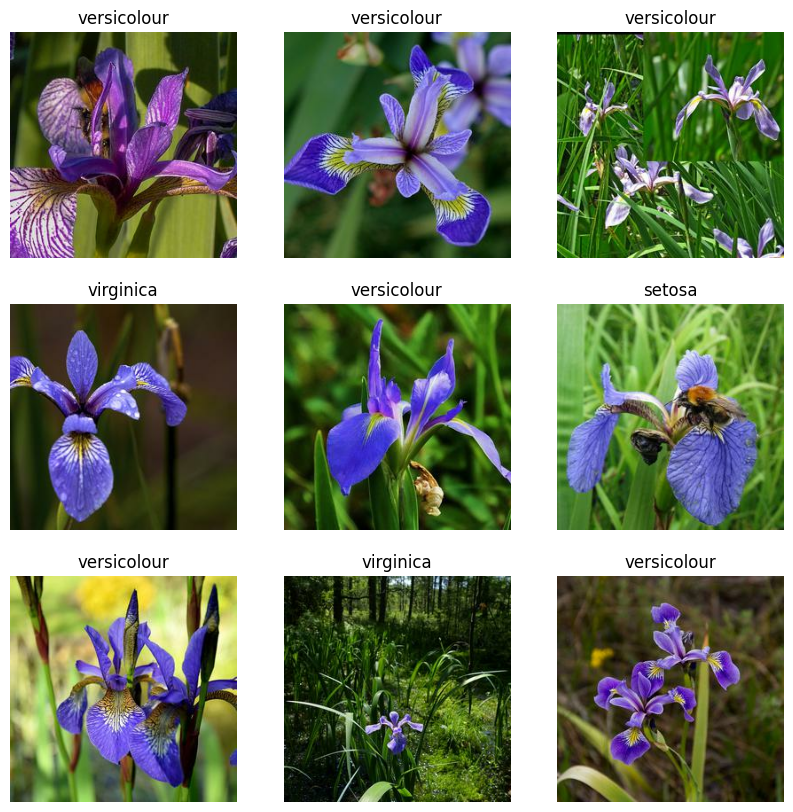

In [16]:
plt.figure(figsize=(10, 10))
for images, labels in raw_train_dataset.take(1):
  #print(labels.numpy())
  for i in range(9):
    # Setting a graph plot for 3x3 images
    ax = plt.subplot(3, 3, i + 1)

    # Plotting the image. All images are converted to numpy and later casted to uint8
    plt.imshow(images[i].numpy().astype("uint8"))

    # Labels are converted from tensor to numpy numbers
    label = int(labels[i].numpy())
    plt.title(class_names[label])
    
    plt.axis("off")

# 2) Preprocessing

## Data Augmentation

In [17]:
'''
  In order to perform data augmentation, use the layers that can alter an image, such as:
  - Random Crop
  - Random Flip
  - Random Translation
  - Random Rotation
  - Random Contrast
  - Random Brightness

  Refer to the documentation:
  https://keras.io/api/layers/preprocessing_layers/image_augmentation/

  You are manipulating an Object type of tf.data.Dataset, and it is a special datatype.
  Refer to the documentation for complex operations on them:
  https://www.tensorflow.org/api_docs/python/tf/data/Dataset
'''

# Lets perform random horizontal flip in 'train'
random_horizontal = tf.keras.layers.RandomFlip(mode="horizontal")

# Performing image augmentation on train
flipped_train_dataset = raw_train_dataset.map(lambda x, y: (random_horizontal(x), y))

# Merging original and flipped datasets
merged_train_dataset = raw_train_dataset.concatenate(flipped_train_dataset)

## Normalization

In [18]:
# Defining the function for MinMax
minmax = tf.keras.layers.Rescaling(1./255)

# Normalizing
clean_train_dataset = merged_train_dataset.map(lambda x, y: (minmax(x), y))
clean_validation_dataset = raw_validation_dataset.map(lambda x, y: (minmax(x), y))
clean_test_dataset = raw_test_dataset.map(lambda x, y: (minmax(x), y))

## Performance Configuration

In [19]:
# This is to take advantage of Cache and prevent I/O operations from blocking the training pipeline
AUTOTUNE = tf.data.AUTOTUNE

clean_train_dataset = clean_train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
clean_validation_dataset = clean_validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)
clean_test_dataset = clean_test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

# 3) AI Model

## Callbacks

In [20]:
# Early Stopping Callback
earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4,)

In [21]:
# Lets create the directory to store the checkpoints
checkpoint_path = "training/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Lets create the actual Callback
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    save_freq='epoch'
  )

## AI Model

In [22]:
# Lets build the model. NOTE: this is the construction of the architecture of the model!
model = tf.keras.Sequential([
  tf.keras.layers.InputLayer(input_shape=img_shape),
  tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1,1), activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(1,1)),
  tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1,1), activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(1,1)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(3, activation="softmax")
])

# Now lets compile the model. NOTE: These are the finishing touches before having a fully functional model
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer='adam', metrics=['accuracy'])

# Now lets train the model!
model.fit(x=clean_train_dataset,
          validation_data=clean_validation_dataset,
          epochs=100,
          callbacks=[earlystopping_callback, checkpoint_callback]
        )

Epoch 1/100
12/12 [==============================] - ETA: 0s - loss: 66.6062 - accuracy: 0.3580
Epoch 1: val_loss improved from inf to 2.45897, saving model to training/cp-0001.ckpt
12/12 [==============================] - 30s 2s/step - loss: 66.6062 - accuracy: 0.3580 - val_loss: 2.4590 - val_accuracy: 0.6125
Epoch 2/100
12/12 [==============================] - ETA: 0s - loss: 1.2729 - accuracy: 0.6003
Epoch 2: val_loss improved from 2.45897 to 1.12120, saving model to training/cp-0002.ckpt
12/12 [==============================] - 17s 2s/step - loss: 1.2729 - accuracy: 0.6003 - val_loss: 1.1212 - val_accuracy: 0.4500
Epoch 3/100
12/12 [==============================] - ETA: 0s - loss: 0.8716 - accuracy: 0.6389
Epoch 3: val_loss improved from 1.12120 to 1.08955, saving model to training/cp-0003.ckpt
12/12 [==============================] - 17s 1s/step - loss: 0.8716 - accuracy: 0.6389 - val_loss: 1.0895 - val_accuracy: 0.6125
Epoch 4/100
12/12 [==============================] - ETA: 0s

# 4) Evaluation

## Loading Model Weights

In [24]:
# Checking the last checkpoint - in this case, the last checkpoint is considered the 'best'
last_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)

# Loading the weights into the model
model.load_weights("training/cp-0003.ckpt")

## Results

In [25]:
model.evaluate(clean_test_dataset)

3/3 [==============================] - 1s 359ms/step - loss: 0.7732 - accuracy: 0.7114


[0.773224949836731, 0.7114093899726868]

## Confusion Matrix

In [30]:
# Function that plots confusion matrix
def plot_confusion_matrix(labels, predictions):
  figure = plt.figure(figsize=(6, 6))
  sns.heatmap(confusion_matrix(labels=labels, predictions=predictions), annot=True,cmap=plt.cm.Blues)
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

In [31]:
# Declaring Variables
model_predictions = []
test_labels = []

for image_batch, labels_batch in clean_test_dataset:
  # Extracting images and doing predictions
  predictions = model.predict(x=image_batch)
  predictions = list(map(lambda x: np.argmax(x), predictions))

  # Extracting labels
  labels = list(map(lambda x: int(x), labels_batch.numpy()))
  
  # Appending
  model_predictions += predictions
  test_labels += labels

1/1 [==============================] - 0s 38ms/step


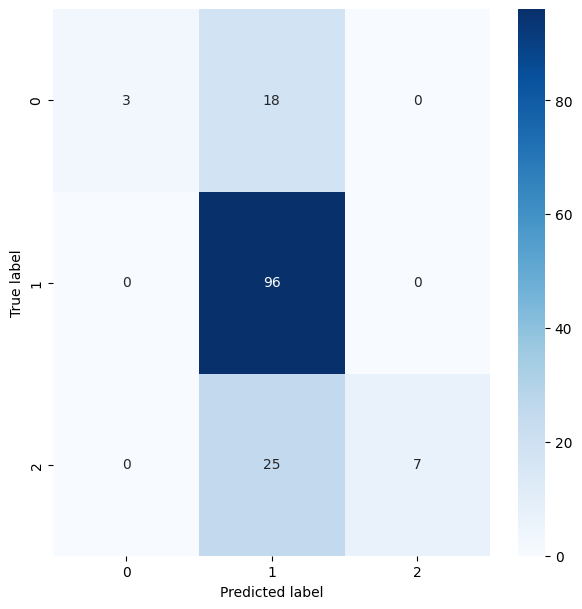

In [32]:
# Lets plot the confusion matrix to check if there is any kind of bias
plot_confusion_matrix(labels=test_labels, predictions=model_predictions)